In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18,resnet50
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import os
import sys
import json
import pandas as pd
import numpy as np
from datetime import datetime
import time
from matplotlib import pyplot as plt
from lopo_dataset import LopoDataset

In [3]:
dataset_name = "ufop"
seed = int(np.random.rand() * 100000000)

In [4]:
torch.manual_seed(seed)

In [5]:
# df = pd.read_csv("../dataset_output/libras_minds/libras_minds_openpose_80_frames.csv")
df = pd.read_csv("../dataset_output/libras_ufop/libras_ufop_openpose_60_frames.csv")

In [6]:
df

,category,video_name,frame,hand_0_0_x,hand_0_0_y,hand_0_0_z,hand_0_1_x,hand_0_1_y,hand_0_1_z,hand_0_2_x,...,pose_22_z,pose_23_x,pose_23_y,pose_23_z,pose_24_x,pose_24_y,pose_24_z,missing_hand,missing_face,person
0,1,p1_c1_s1_0,1,0.555086,0.561309,0.396433,0.547985,0.570326,0.402954,0.542236,...,0.751818,0.433051,0.966384,0.792620,0.449503,0.930953,0.673173,False,False,1.0
1,1,p1_c1_s1_0,2,0.552441,0.554763,0.376937,0.544950,0.563844,0.328017,0.539501,...,0.721404,0.431155,0.966412,0.771990,0.449501,0.928337,0.667928,False,False,1.0
2,1,p1_c1_s1_0,3,0.540484,0.558278,0.014662,0.539830,0.565252,0.043459,0.532311,...,0.745815,0.433046,0.966367,0.777363,0.449523,0.928312,0.661847,False,False,1.0
3,1,p1_c1_s1_0,4,0.539812,0.537244,0.100900,0.534094,0.548904,0.083215,0.531067,...,0.697552,0.433064,0.966390,0.749232,0.449475,0.930948,0.649300,False,False,1.0
4,1,p1_c1_s1_0,5,0.530725,0.526807,0.142478,0.524336,0.534430,0.150466,0.517610,...,0.727615,0.433072,0.966384,0.772875,0.449477,0.928342,0.647910,False,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182395,47,p5_c4_s9_10,55,0.522440,0.436927,0.275950,0.533989,0.446403,0.045277,0.532805,...,0.705954,0.426990,0.950059,0.665721,0.437205,0.898362,0.538676,False,False,5.0
182396,47,p5_c4_s9_10,56,0.522440,0.436927,0.275950,0.533989,0.446403,0.045277,0.532805,...,0.705954,0.426990,0.950059,0.665721,0.437205,0.898362,0.538676,False,False,5.0
182397,47,p5_c4_s9_10,57,0.522440,0.436927,0.275950,0.533989,0.446403,0.045277,0.532805,...,0.705954,0.426990,0.950059,0.665721,0.437205,0.898362,0.538676,False,False,5.0
182398,47,p5_c4_s9_10,58,0.522440,0.436927,0.275950,0.533989,0.446403,0.045277,0.532805,...,0.705954,0.426990,0.950059,0.665721,0.437205,0.898362,0.538676,False,False,5.0


In [7]:
# Minds only
if "person" not in df.columns:
    import re
    df["person"] = df["video_name"].apply(lambda i: int(re.findall(r".*Sinalizador(\d+)-.+.mp4", i)[0]))

In [8]:
frames = 60
people = df["person"].unique()
validate_people = people[-1:]
test_people = people[-2:-1]
train_people = people[:-2]

In [9]:
people

array([1., 2., 3., 4., 5.])

In [10]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [41]:
print("Processing train")
train_dataset = LopoDataset(df, frames, transform, transform_distance=False, person_in=train_people, seed=seed)
print("Processing test")
test_dataset = LopoDataset(df, frames, transform, transform_distance=False, augment=False, person_in=test_people, seed=seed)
print("Processing validate")
validate_dataset = LopoDataset(df, frames, transform, transform_distance=False, augment=False, person_in=validate_people, seed=seed)
print("Data loaded")

Processing train
Processing test
Processing validate
Data loaded


In [154]:
# Load dataset
# train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
# test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
# validate_dataset = datasets.ImageFolder(root=validate_dir, transform=transform)

In [155]:
# # Split dataset into train and test
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [42]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=64, shuffle=False)

In [13]:
# Load pre-trained ResNet18 model
resnet = resnet18(pretrained=True)

/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
# Load pre-trained ResNet18 model
resnet = resnet50(pretrained=True)

/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/dudu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 89.4MB/s]


In [44]:
num_ftrs = resnet.fc.in_features

In [45]:
num_features = len(df["category"].unique())
num_features

56

In [46]:
# Modify the fully connected layer to match the number of classes
# resnet.fc = nn.Linear(num_ftrs, num_features)

In [47]:
# Add an extra dense layer
resnet.fc = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, num_features)
)

In [48]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet.parameters(), lr=10e-5)
optimizer_parameters = {
    "lr": 1e-4,
    "weight_decay": 1e-5
}
optimizer = optim.Adam(resnet.parameters(), **optimizer_parameters)

In [49]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [50]:
len(test_loader.dataset)

583

In [51]:
epochs = 25
history = {"loss": [], "accuracy": [], "val_accuracy": []}
best_val_loss = float('inf')
best_val_accuracy = 0
best_model_weights = resnet.state_dict()
patience = 5
counter = 0
for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        if len(inputs) == 1:
            continue
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    
    resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validate_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        val_loss = criterion(outputs, labels)
        history["loss"].append(float(epoch_loss))
        history["accuracy"].append(float(train_accuracy))
        history["val_accuracy"].append(float(val_accuracy))
        
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = resnet.state_dict()
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. No improvement in validation loss.")
            break

    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(str(datetime.now()))

Epoch 1/25, Train Loss: 3.8436, Train Accuracy: 0.0603, Validation Loss: 3.7248, Validation Accuracy: 0.1083
2024-04-02 18:41:06.290669
Epoch 2/25, Train Loss: 3.0256, Train Accuracy: 0.2645, Validation Loss: 2.6845, Validation Accuracy: 0.4367
2024-04-02 18:41:14.191021
Epoch 3/25, Train Loss: 2.0390, Train Accuracy: 0.5350, Validation Loss: 1.3388, Validation Accuracy: 0.6333
2024-04-02 18:41:22.145422
Epoch 4/25, Train Loss: 1.2652, Train Accuracy: 0.7392, Validation Loss: 1.3324, Validation Accuracy: 0.6767
2024-04-02 18:41:30.097462
Epoch 5/25, Train Loss: 0.8042, Train Accuracy: 0.8438, Validation Loss: 1.4082, Validation Accuracy: 0.7283
2024-04-02 18:41:38.055215
Epoch 6/25, Train Loss: 0.5212, Train Accuracy: 0.9127, Validation Loss: 0.7814, Validation Accuracy: 0.8100
2024-04-02 18:41:45.990247
Epoch 7/25, Train Loss: 0.4040, Train Accuracy: 0.9262, Validation Loss: 1.2912, Validation Accuracy: 0.7767
2024-04-02 18:41:53.853252
Epoch 8/25, Train Loss: 0.3037, Train Accuracy: 

In [52]:
# Load the best model weights
resnet.load_state_dict(best_model_weights)
print("Best val accuracy:", best_val_accuracy)

Best val accuracy: 0.855


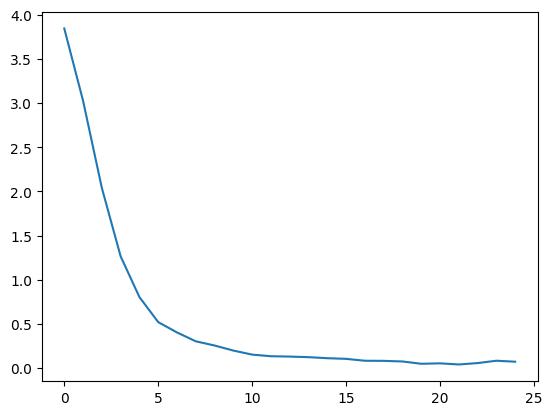

In [53]:
plt.plot(history["loss"])

In [54]:
resnet.eval()
correct = 0
total = 0
class_correct = list(0. for _ in range(num_features))
class_total = list(0. for _ in range(num_features))

In [55]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [56]:
# Evaluate on test set
resnet.eval()
correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = correct / total
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
print(f"Accuracy on the test set: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Accuracy on the test set: 0.8233
Precision: 0.8328, Recall: 0.8237, F1 Score: 0.7950


In [58]:
accuracy = correct / total
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.8233


In [59]:
categories = [i+1 for i in range(num_features)]

In [60]:
precisions = []
for i in range(num_features):
    precision = class_correct[i] / class_total[i]
    precisions.append(precision)
    if precision < 1:
        print(f"Precision of class {i}: {precision:.4f}")
# plt.bar(categories, precision)

Precision of class 0: 0.0000
Precision of class 1: 0.9091
Precision of class 2: 0.0000
Precision of class 4: 0.6000
Precision of class 5: 0.1000
Precision of class 8: 0.8000
Precision of class 11: 0.8182
Precision of class 14: 0.9000
Precision of class 20: 0.7692
Precision of class 21: 0.9091
Precision of class 22: 0.0833
Precision of class 23: 0.8000
Precision of class 26: 0.9000
Precision of class 27: 0.7000
Precision of class 29: 0.4000
Precision of class 34: 0.0000
Precision of class 35: 0.8000
Precision of class 42: 0.2727
Precision of class 47: 0.3636
Precision of class 48: 0.9000
Precision of class 50: 0.4000
Precision of class 53: 0.7000


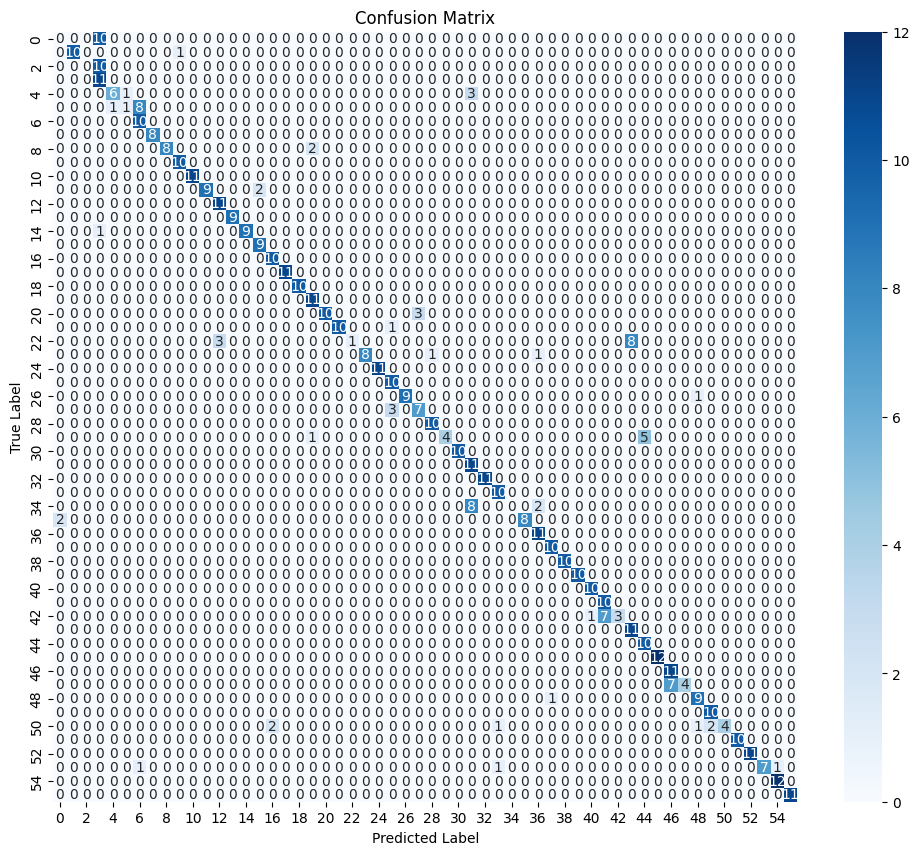

In [61]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [62]:
0.91 - accuracy

0.08667238421955403

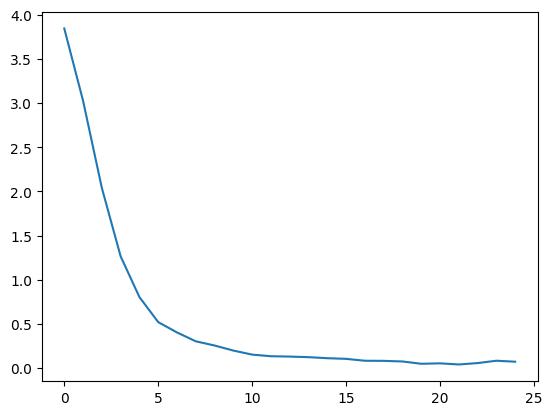

In [63]:
plt.plot(history["loss"])

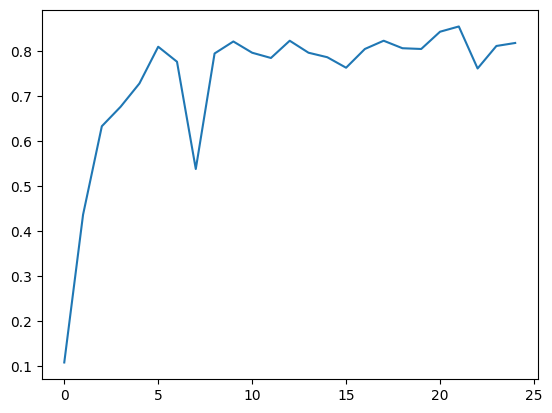

In [64]:
plt.plot(history["val_accuracy"])

In [136]:
result = {
    "dataset_name": dataset_name,
    "frames": frames,
    "seed": seed,
    "epochs": epochs,
    "last_epoch": epoch,
    "test_people": test_people.tolist(),
    "validate_people": validate_people.tolist(),
    "resnet_fc_layer": str(resnet.fc),
    "history": history,
    "true_labels": true_labels,
    "predicted_labels": predicted_labels,
    "test_accuracy": accuracy,
    "test_precision": precision,
    "test_recall": float(recall),
    "test_f1_score": float(f1),
}
result

{'dataset_name': 'minds',
 'frames': 80,
 'seed': 4321947,
 'epochs': 25,
 'last_epoch': 24,
 'test_people': [11],
 'validate_people': [12],
 'resnet_fc_layer': 'Sequential(\n  (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (1): Linear(in_features=512, out_features=128, bias=True)\n  (2): ReLU()\n  (3): Dropout(p=0.5, inplace=False)\n  (4): Linear(in_features=128, out_features=20, bias=True)\n)',
 'history': {'loss': [2.873230065084947,
   2.4439844597356553,
   2.006009357209494,
   1.57887721584336,
   1.1804543098975322,
   0.8805239845168367,
   0.660664744939585,
   0.49992811007887933,
   0.3859418735748044,
   0.3065069536202138,
   0.22762283088643268,
   0.18747660629684593,
   0.15256743148622534,
   0.13782548378678602,
   0.1257682118977037,
   0.11136088605837932,
   0.08912399425978203,
   0.09196242581205229,
   0.08347909440265071,
   0.07801123394286708,
   0.06173050956555597,
   0.055808823719029635,
   0.056105447213684594,


In [137]:
validate_people.item()

12

In [138]:
for k, v in result.items():
    print(k, type(v))

dataset_name <class 'str'>
frames <class 'int'>
seed <class 'int'>
epochs <class 'int'>
last_epoch <class 'int'>
test_people <class 'list'>
validate_people <class 'list'>
resnet_fc_layer <class 'str'>
history <class 'dict'>
true_labels <class 'list'>
predicted_labels <class 'list'>
test_accuracy <class 'float'>
test_precision <class 'float'>
test_recall <class 'float'>
test_f1_score <class 'float'>


In [145]:
file_name = str(datetime.now()).replace(":", "_").replace(" ", "_")
file_path = os.path.join("results", dataset_name, file_name + ".json")
model_path = os.path.join("results", dataset_name, "models", file_name + ".pth")
with open(file_path, "w") as f:
    json.dump(result, f, default=int)

torch.save(resnet.state_dict(), model_path)

In [143]:
file_name

'2024-03-31_14_42_11.375710'